# Корректно ли работает система сплитования? АА-тест.

При проведении АА-теста было бы здорово убедиться в том, что наша система сплитования работает корректно, и ключевая метрика не отличается между 0 и 1 группой не только в конкретно нашем АА-тесте, но и в целом.  

Мы будем многократно извлекать подвыборки с повторениями из наших данных, проводить тест, и в конце посмотрим, в каком проценте случаев нам удалось отклонить нулевую гипотезу.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import pandahouse
from scipy import stats
import seaborn as sns

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

In [5]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20230320.feed_actions 
WHERE toDate(time) between '2023-02-23' and '2023-03-01'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [16]:
df.head()

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667


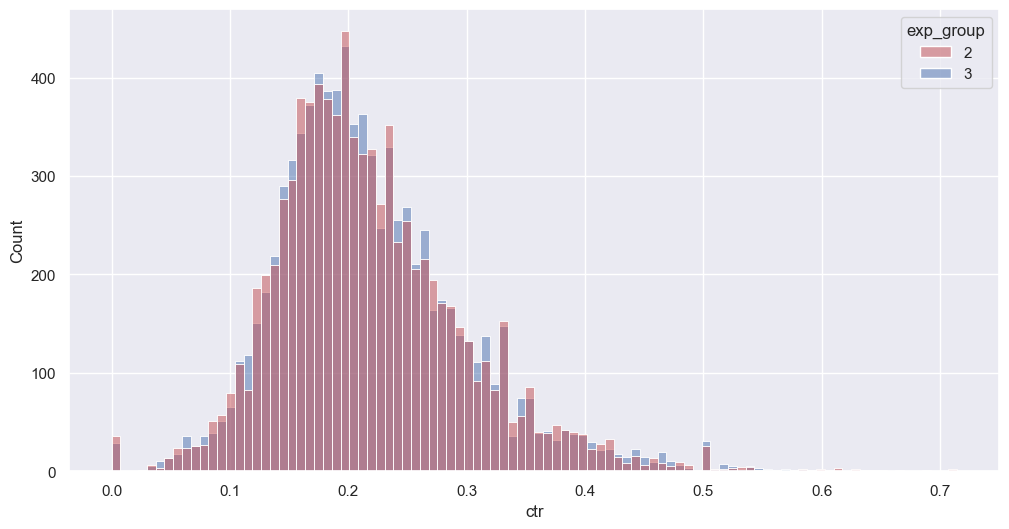

In [10]:
sns.set(rc={"figure.figsize":(12, 6)}) 
plt.tight_layout()

ax = sns.histplot(data=df, x='ctr', hue='exp_group', palette=['r', 'b'])

Распределение похоже на нормальное, также есть выбросы.

## Симуляция 10000 АА-тестов

In [11]:
# Симуляция 10000 АА-тестов на выборках по 500 пользователей из каждой группы
n_tests = 10000
n_samples = 500
p_values_list = []
for i in range(n_tests):
    group_2 = df[df['exp_group']==2].ctr.sample(n_samples, replace=True)
    group_3 = df[df['exp_group']==3].ctr.sample(n_samples, replace=True)
    # Т-тест
    p_value = stats.ttest_ind(group_2, group_3, equal_var=False)[1]
    p_values_list.append(p_value)

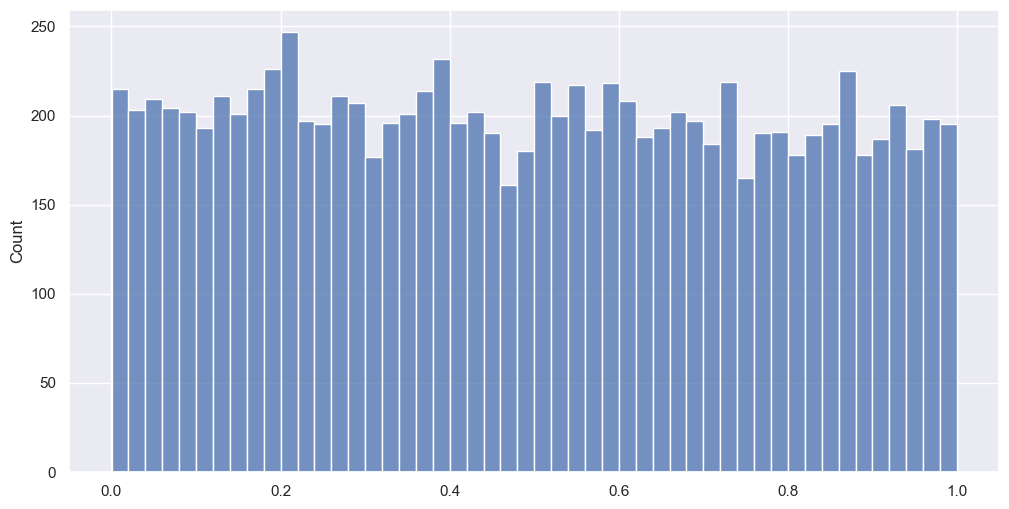

In [14]:
ax = sns.histplot(p_values_list, bins=50)

In [15]:
p_values = pd.Series(p_values_list)
prcnt = 100 * len(p_values[p_values<=0.05]) / len(p_values)
print("Всего p-values <= 0.05:", f"{prcnt}%")

Всего p-values <= 0.05: 5.23%


## Вывод

Система сплитования работает корректно, только в 5.23% случаев p-value оказалось ниже или равно 0.05.